In [ ]:
# Install dependencies (if needed)
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126
# If no CUDA is available, use the command below instead and comment out the above command
#!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
!pip install pillow numpy tqdm matplotlib

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class LightMycobacteriumUNet(nn.Module):
    """
    Implementation of the U-net model from paper https://doi.org/10.1016/j.engappai.2025.112503
    """
    def __init__(self, n_channels=1, n_classes=1):
        super(LightMycobacteriumUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        f = 24 

        # --- ENCODER ---
        self.inc = DoubleConv(n_channels, f)
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(f, f * 2)
        )

        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(f * 2, f * 4)
        )

        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(f * 4, f * 8)
        )

        self.down4 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(f * 8, f * 16)
        )

        # --- DECODER ---
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up1 = DoubleConv(f * 16 + f * 8, f * 8)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up2 = DoubleConv(f * 8 + f * 4, f * 4)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up3 = DoubleConv(f * 4 + f * 2, f * 2)

        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up4 = DoubleConv(f * 2 + f, f)

        self.outc = nn.Conv2d(f, n_classes, kernel_size=1)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1) 
        x = self.conv_up1(x)
        
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv_up2(x)
        
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv_up3(x)
        
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv_up4(x)
        
        logits = self.outc(x)
        
        return torch.sigmoid(logits)

In [10]:
def min_max_normalize(tensor):
    """
    Implements Eq. (1) from the paper: (F - Min) / (Max - Min) 
    """
    min_val = tensor.min()
    max_val = tensor.max()
    
    # Avoid division by zero
    if max_val - min_val > 0:
        return (tensor - min_val) / (max_val - min_val)
    else:
        return tensor - min_val

In [11]:
import os
import glob
from random import randrange
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import crop
from torchvision import transforms
from PIL import Image
import numpy as np

class MycobacteriumDataset(Dataset):
    def __init__(self, root_dir, val=False):
        """
        Args:
            root_dir (str): Path to the directory containing experiment folders.
        """
        self.root_dir = root_dir
        self.val = val
        self.image_mask_pairs = self._find_pairs()

    def _in_val(self, pos_name):
        """
        We'll use any files under Pos*09, Pos*10, Pos*19, and Pos*20 as validation set
        """
        return pos_name.endswith("09") or pos_name.endswith("10") or pos_name.endswith("19") or pos_name.endswith("20") 

    def _find_pairs(self):
        pairs = []
        raw_folders = glob.glob(os.path.join(self.root_dir, "*_raw_data*"))
        
        for raw_folder in raw_folders:
            # Replaces '_raw_data' with '_masks'
            mask_folder = raw_folder.replace("_raw_data", "_masks")
            
            if not os.path.exists(mask_folder):
                print(f"Warning: Mask folder not found for {raw_folder}")
                continue

            # Look for PosXXX subfolders inside raw_data
            pos_folders = glob.glob(os.path.join(raw_folder, "Pos*"))

            for pos_path in pos_folders:
                if self.val and not self._in_val(pos_path):
                    continue
                elif not self.val and self._in_val(pos_path):
                    continue
                
                pos_name = os.path.basename(pos_path)
                
                # Corresponding Pos folder in masks
                mask_pos_path = os.path.join(mask_folder, pos_name, "PreprocessedPhaseMasks")
                
                if not os.path.exists(mask_pos_path):
                    continue

                # Find all .tif(f) images in the raw Pos folder
                if os.path.exists(os.path.join(pos_path, "aphase")):
                    img_files = glob.glob(os.path.join(pos_path, "aphase", "img_*.tif*"))
                elif os.path.exists(os.path.join(pos_path, "PreprocessedPhase")):
                    img_files = glob.glob(os.path.join(pos_path, "PreprocessedPhase", "img_*.tif*"))
                else:
                    continue
                
                for img_path in img_files:
                    # Find mask filename
                    # Some masks and files have different file extensions, so we need to use glob
                    glob_mask_filename = f"MASK_{os.path.basename(img_path)[:-2]}*"
                    mask_files = glob.glob(os.path.join(mask_pos_path, glob_mask_filename))

                    for mask_path in mask_files:
                        pairs.append((img_path, mask_path))
                        break
                            
        
        print(f"Found {len(pairs)} image-mask pairs.")
        return pairs

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]

        image = Image.open(img_path)
        mask = Image.open(mask_path)

        mask_np = np.array(mask)
        
        mask_binary = (mask_np > 0).astype(np.float32)
        
        mask_tensor = torch.from_numpy(mask_binary).unsqueeze(0)

        # Resize mask to match image (may not be needed?)
        resize_mask = transforms.Resize(image.size, interpolation=transforms.InterpolationMode.NEAREST)
        mask = resize_mask(mask_tensor)

        to_tensor = transforms.ToTensor()
        image_tensor = to_tensor(image)

        width, height = image.size

        # Crop image to 768x448 px, with random offset
        crop_top = randrange(height - 768)
        crop_left = randrange(width - 448)
        
        image_tensor = crop(image_tensor, crop_top, crop_left, 768, 448)
        mask_tensor = crop(mask_tensor, crop_top, crop_left, 768, 448)

        image_tensor = min_max_normalize(image_tensor).float()

        mask_tensor = (mask_tensor > 1e-8).float()

        return image_tensor, mask_tensor


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
import random
import time
from tqdm import tqdm

class JointAugmentation:
    """
    Applies random rotation, shift, zoom, and flip to BOTH image and mask 
    simultaneously, as described in Section 3.3 of paper
    """
    def __call__(self, image, mask):
        # Random Horizontal Flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random Vertical Flip
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random Rotation
        if random.random() > 0.5:
            angle = random.uniform(-15, 15)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)
            
        # Random Affine
        if random.random() > 0.5:
            ret = TF.affine(
                torch.cat((image, mask), dim=0), 
                angle=0, 
                translate=(0.1, 0.1), 
                scale=random.uniform(0.9, 1.1), 
                shear=0
            )
            image, mask = torch.split(ret, 1, dim=0)

        return image, mask

In [13]:
def dice_coeff(pred, target, smooth=1e-6):
    """
    Calculates Dice Score: 2 * (Intersection) / (Union) [cite: 351]
    """
    pred = pred.view(-1)
    target = target.view(-1)
    
    pred = (pred > 0.5).float()
    
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice.item()

In [14]:
def train_model(model, train_loader, val_loader, device, epochs=250):
    """
    Training loop implementing parameters from Section 3.3.
    """
    criterion = nn.BCELoss()
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
    
    augmenter = JointAugmentation()
    
    best_val_dice = 0.0
    history = {'train_loss': [], 'train_dice': [], 'val_loss': [], 'val_dice': []}
    
    print(f"Starting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0

        train_dice_score = 0.0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False):
            images = images.to(device)
            masks = masks.to(device)

            with torch.no_grad():
                for i in range(images.size(0)):
                    images[i], masks[i] = augmenter(images[i], masks[i])

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, masks)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            train_dice_score += dice_coeff(outputs, masks) * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_dice = train_dice_score / len(train_loader.dataset)

        history['train_loss'].append(epoch_loss)
        history['train_dice'].append(epoch_dice)

        model.eval()
        val_running_loss = 0.0
        val_dice_score = 0.0
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False):
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                
                loss = criterion(outputs, masks)
                val_running_loss += loss.item() * images.size(0)
                
                val_dice_score += dice_coeff(outputs, masks) * images.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_dice = val_dice_score / len(val_loader.dataset)
        
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} | Time: {epoch_time:.0f}s | "
              f"Train Loss: {epoch_loss:.4f} | Train Dice: {epoch_dice:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), "best_mycobacterium_model.pth")
            print(f"  >>> New Best Model Saved (Dice: {best_val_dice:.4f})")

    return history

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

EPOCHS = 250
DATASET_PATH = "/path/to/dataset"

train_dataset = MycobacteriumDataset(root_dir=DATASET_PATH, val=False)
val_dataset = MycobacteriumDataset(root_dir=DATASET_PATH, val=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

model = LightMycobacteriumUNet(n_channels=1, n_classes=1).to(device)

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=EPOCHS 
)

In [35]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

def training_curve_plot(title, x, train_costs, test_costs, train_accuracy,
                        test_accuracy, batch_size, learning_rate, epochs):
    """Plotting function copied from assignment instructions"""
    lg=18
    md=13
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} | Epochs:{epochs} |'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    axs[0].plot(x, train_costs,
                label=f'Final train cost: {train_costs[-1]:.4f}')
    axs[0].plot(x, test_costs, label=f'Final test cost: {test_costs[-1]:.4f}')
    axs[0].set_title('Loss', fontsize=md)
    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Loss', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    axs[1].plot(x, train_accuracy,
                label=f'Final train accuracy: {100*train_accuracy[-1]:.2f}%')
    axs[1].plot(x, test_accuracy,
                label=f'Final test accuracy: {100*test_accuracy[-1]:.2f}%')
    axs[1].set_title('Dice', fontsize=md)
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Dice (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)
    plt.show()

In [266]:
x = [e for e in range(EPOCHS)]

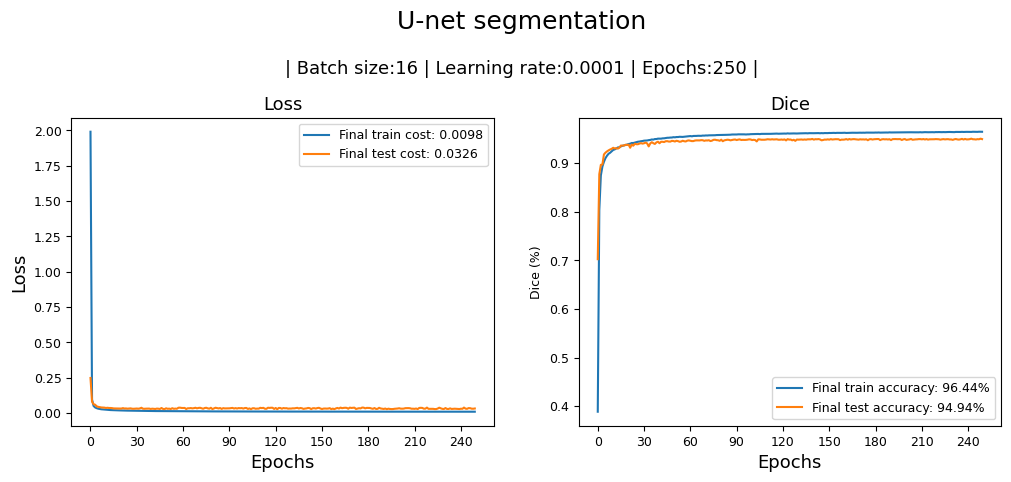

In [267]:
training_curve_plot("U-net segmentation", x, history['train_loss'], history['val_loss'], history['train_dice'], history['val_dice'], 16, 1e-4, EPOCHS)


Running inference on: cuda
Weights loaded successfully.


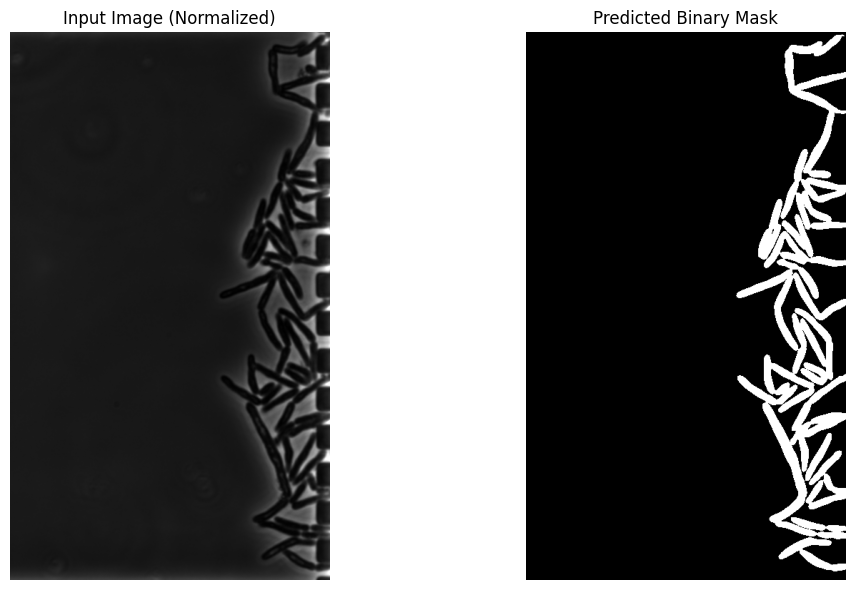

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def process_image(loader):
    img = Image.open(image_path)
    
    img_np = np.array(img)
    img_tensor = torch.from_numpy(img_np).float()

    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)

    *batch_dims, H, W = img_tensor.shape

    new_H = H - (H % 16)
    new_W = W - (W % 16)

    img_tensor = img_tensor[..., :new_H, :new_W]
    
    min_val = img_tensor.min()
    max_val = img_tensor.max()
    
    if max_val - min_val > 0:
        img_tensor = (img_tensor - min_val) / (max_val - min_val)
    else:
        img_tensor = img_tensor - min_val

    return img_tensor

def visualize_prediction(model, input_tensor, device):
    """
    Runs inference and plots input image and prediction
    """
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        prediction_mask = (output > 0.5).float()

    input_display = input_tensor.squeeze().cpu().numpy()
    pred_display = prediction_mask.squeeze().cpu().numpy()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(input_display, cmap='gray')
    axes[0].set_title("Input Image (Normalized)")
    axes[0].axis('off')
    
    axes[1].imshow(pred_display, cmap='gray', vmin=0, vmax=1)
    axes[1].set_title("Predicted Binary Mask")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

MODEL_PATH = "best_mycobacterium_model.pth"
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running inference on: {device}")

model = LightMycobacteriumUNet(n_channels=1, n_classes=1).to(device)

try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print("Weights loaded successfully.")
except FileNotFoundError:
    print("Error: Model weights file not found. Please train the model first.")
    exit()

# Take a random image from validation set and visualize prediction
for img, mask in test_loader:
    img = img.to(device)
    visualize_prediction(model, img, device)
    break
